<a href="https://colab.research.google.com/github/NirmalMJohn/DataScience_Project/blob/main/Main_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler


In [ ]:
# Install the tslearn package
!pip install tslearn
import tslearn
print(tslearn.__version__)

0.6.3


In [ ]:
from tslearn.clustering import TimeSeriesKMeans

## **Usefull Functions for Analysis**

In [ ]:
def merge_imputed_data(tariff_data, missing_data):
    """
    Merges the imputed missing data with the original data and returns the combined DataFrame.

    Parameters:
    tariff_data (pd.DataFrame): The original DataFrame containing the consumption data with potential missing timestamps.
                             It must contain the columns 'LCLid', 'DateTime', and 'Consumption'.
    missing_data (pd.DataFrame): The DataFrame containing the imputed missing data. It must contain the columns
                                 'LCLid', 'MissingDateTime', and 'Consumption' along with 'Hour' and 'Month'.

    Returns:
    pd.DataFrame: A combined DataFrame with the original tariff data and the imputed missing data, sorted by 'LCLid' and 'DateTime'.
    """
    # Append MissingDateTime to original DateTime column in std_data to match the structure
    missing_data['DateTime'] = missing_data['MissingDateTime']
    missing_data = missing_data.drop(columns=['MissingDateTime', 'Hour', 'Month'])

    # Merge the imputed data back to the original std_data
    tariff_data_imputed = pd.concat([tariff_data, missing_data], ignore_index=True)
    tariff_data_imputed = tariff_data_imputed.sort_values(by=['LCLid', 'DateTime']).reset_index(drop=True)

    return tariff_data_imputed

In [ ]:
def identify_outliers_iqr(data):
    """
    Identifies outliers in the data based on IQR.

    Parameters:
    - data: DataFrame containing the 'TotalConsumption' column.

    Returns:
    - DataFrame with outliers.
    """
    Q1 = data['TotalConsumption'].quantile(0.25)
    Q3 = data['TotalConsumption'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data['TotalConsumption'] < lower_bound) | (data['TotalConsumption'] > upper_bound)]
    return outliers

def plot_total_consumption_distribution(total_consumption, outliers, title):
    """
    Plots the distribution of total consumption values with outliers
    highlighted as legends.

    Parameters:
    - total_consumption: DataFrame containing LCLid and TotalConsumption
      columns for STD & ToU.
    - outliers: DataFrame containing LCLid and TotalConsumption of the outliers.
    - title: Title for the plot.

    The function uses a boxplot to visualize the distribution and includes legends for outliers
    for easy identification.
    """
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='TotalConsumption', data=total_consumption)

    # Create a color palette for the legends
    unique_outliers = outliers.drop_duplicates(subset=['LCLid'])
    print(f"Unique outliers:\n{unique_outliers}")

    palette = sns.color_palette("hsv", len(unique_outliers))

    # Plot legends for each unique outlier LCLid
    handles = []
    for i in range(unique_outliers.shape[0]):
        handles.append(plt.Line2D([0], [0], marker='o', color='w', label=unique_outliers.iloc[i]['LCLid'],
                                  markerfacecolor=palette[i], markersize=10))

    plt.legend(title='Outlier LCLid', handles=handles)
    plt.title(title)
    plt.xlabel('Total Consumption')
    plt.show()

    return unique_outliers[['LCLid']].reset_index(drop=True)


In [ ]:
def normalize_time_series_data(input_df):
    """
    Normalize time-series data in a DataFrame using Min-Max scaling.

    This function normalizes the time-series data (excluding the first identifier column)
    in the provided DataFrame using Min-Max scaling.

    Parameters:
    input_df (pd.DataFrame): DataFrame containing the time-series data with the first column as the identifier.

    Returns:
    pd.DataFrame: DataFrame with normalized time-series data.
    """
    # Extract time-series columns (excluding the first identifier column)
    time_series_data = input_df.iloc[:, 1:]

    # Initialize the scaler
    scaler = MinMaxScaler()

    # Fit and transform the time-series data
    normalized_data = scaler.fit_transform(time_series_data)

    # Create a new DataFrame with the normalized data
    normalized_df = pd.DataFrame(normalized_data, columns=time_series_data.columns)

    # Add the identifier column back
    normalized_df.insert(0, input_df.columns[0], input_df[input_df.columns[0]])

    return normalized_df


In [ ]:
def perform_dtw_clustering(normalized_df, n_clusters):
    """
    Perform K-means clustering using DTW on normalized time-series data.

    Parameters:
    normalized_df (pd.DataFrame): DataFrame containing normalized time-series data with the first column as the identifier.
    n_clusters (int): The number of clusters to form.

    Returns:
    tuple: DataFrame with an additional column for cluster labels and the KMeans model.
    """
    time_series_data = normalized_df.iloc[:, 1:].values
    kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)
    labels = kmeans.fit_predict(time_series_data)
    normalized_df['Cluster'] = labels
    return normalized_df, kmeans

In [ ]:
def plot_clusters(normalized_df, kmeans):
    """
    Plot the clusters formed by K-means clustering with DTW.

    Parameters:
    normalized_df (pd.DataFrame): DataFrame containing normalized time-series
    data with cluster labels.
    kmeans (TimeSeriesKMeans): The KMeans model.
    """
    time_series_data = normalized_df.iloc[:, 1:-1].values
    cluster_labels = normalized_df['Cluster'].values
    n_clusters = len(np.unique(cluster_labels))

    plt.figure(figsize=(15, 10))
    for cluster in range(n_clusters):
        cluster_data = time_series_data[cluster_labels == cluster]
        for series in cluster_data:
            plt.plot(series, alpha=0.5)
        plt.plot(kmeans.cluster_centers_[cluster].ravel(), 'k-', linewidth=2)
    plt.title(f'Clusters with KMeans and DTW (k={n_clusters})')
    plt.xlabel('Time Points')
    plt.ylabel('Normalized Value')
    plt.show()

## **Sampling Data taking 50 unique LCLid of customers in STD and ToU Tariff from Year 2013**

In [ ]:
import pandas as pd

filename = '/content/drive/MyDrive/LCL-FullData/CC_LCL-FullData.csv'
chunksize = 10**6  # Adjust based on available memory

# Desired date range
start_date = pd.to_datetime('2013-01-01')
end_date = pd.to_datetime('2014-02-28')

# Step 1: Identify IDs with complete date coverage
std_ids = set()
tou_ids = set()

# Read file in chunks
for chunk in pd.read_csv(filename, chunksize=chunksize, parse_dates=['DateTime']):
    # Ensure DateTime column is properly parsed
    chunk['DateTime'] = pd.to_datetime(chunk['DateTime'], errors='coerce')

    # Filter by date range first
    chunk = chunk[(chunk['DateTime'] >= start_date) & (chunk['DateTime'] <= end_date)]

    if len(std_ids) < 50:
        std_chunk = chunk[chunk['stdorToU'] == 'Std']
        grouped_std = std_chunk.groupby('LCLid')
        for name, group in grouped_std:
            if group['DateTime'].min() <= start_date and group['DateTime'].max() >= end_date:
                std_ids.add(name)
            if len(std_ids) >= 50:
                break

    if len(tou_ids) < 50:
        tou_chunk = chunk[chunk['stdorToU'] == 'ToU']
        grouped_tou = tou_chunk.groupby('LCLid')
        for name, group in grouped_tou:
            if group['DateTime'].min() <= start_date and group['DateTime'].max() >= end_date:
                tou_ids.add(name)
            if len(tou_ids) >= 50:
                break

    # Check if we have enough IDs
    if len(std_ids) >= 50 and len(tou_ids) >= 50:
        break

std_ids = list(std_ids)
tou_ids = list(tou_ids)

# Debug: Check if the correct IDs were identified
print(f"STD IDs (count: {len(std_ids)}): {std_ids[:5]}")  # Print first 5 IDs for verification
print(f"TOU IDs (count: {len(tou_ids)}): {tou_ids[:5]}")  # Print first 5 IDs for verification

# Step 2: Collect all rows for selected IDs
std_data = []
tou_data = []

for chunk in pd.read_csv(filename, chunksize=chunksize, parse_dates=['DateTime']):
    chunk['DateTime'] = pd.to_datetime(chunk['DateTime'], errors='coerce')

    std_chunk = chunk[chunk['LCLid'].isin(std_ids) & (chunk['stdorToU'] == 'Std')]
    tou_chunk = chunk[chunk['LCLid'].isin(tou_ids) & (chunk['stdorToU'] == 'ToU')]

    std_data.append(std_chunk)
    tou_data.append(tou_chunk)

# Concatenate the dataframes only if they are not empty
if std_data:
    std_data = pd.concat(std_data)
else:
    std_data = pd.DataFrame()

if tou_data:
    tou_data = pd.concat(tou_data)
else:
    tou_data = pd.DataFrame()

# Filter concatenated data by date range to ensure correctness
std_data = std_data[(std_data['DateTime'] >= start_date) & (std_data['DateTime'] <= end_date)]
tou_data = tou_data[(tou_data['DateTime'] >= start_date) & (tou_data['DateTime'] <= end_date)]

# Debug: Check the range of dates in the resulting data
print("STD Data Date Range:", std_data['DateTime'].min(), "-", std_data['DateTime'].max())
print("TOU Data Date Range:", tou_data['DateTime'].min(), "-", tou_data['DateTime'].max())

print("STD Data:")
print(std_data.head())
print("\nTOU Data:")
print(tou_data.head())

STD IDs (count: 50): ['MAC000002', 'MAC000025', 'MAC000023', 'MAC000039', 'MAC000056']
TOU IDs (count: 50): ['MAC000051', 'MAC000017', 'MAC000106', 'MAC000088', 'MAC000015']
STD Data Date Range: 2013-01-01 00:00:00 - 2014-02-28 00:00:00
TOU Data Date Range: 2013-01-01 00:00:00 - 2014-02-28 00:00:00
STD Data:
          LCLid stdorToU            DateTime KWH/hh (per half hour) 
3840  MAC000002      Std 2013-01-01 00:00:00                  0.219 
3841  MAC000002      Std 2013-01-01 00:30:00                  0.241 
3842  MAC000002      Std 2013-01-01 01:00:00                  0.191 
3843  MAC000002      Std 2013-01-01 01:30:00                  0.235 
3844  MAC000002      Std 2013-01-01 02:00:00                  0.182 

TOU Data:
               LCLid stdorToU            DateTime KWH/hh (per half hour) 
134158912  MAC000005      ToU 2013-01-01 00:00:00                  0.096 
134158913  MAC000005      ToU 2013-01-01 00:30:00                  0.111 
134158914  MAC000005      ToU 2013-01-01 01

#**Preprocessing**

In [ ]:
# Renaming the Column name KWH/hh (per half hour) to Consumption in std Data
std_data.rename(columns={'KWH/hh (per half hour) ': 'Consumption'}, inplace=True)
tou_data.rename(columns={'KWH/hh (per half hour) ': 'Consumption'}, inplace=True)

<ipython-input-11-f0d79ed1ce01>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  std_data.rename(columns={'KWH/hh (per half hour) ': 'Consumption'}, inplace=True)


In [ ]:
# Droping Column stdorTou from both Std & ToU dataframes
std_data.drop('stdorToU', axis=1, inplace=True)
tou_data.drop('stdorToU', axis=1, inplace=True)

In [ ]:
# Resetting the Index of Dataframes
std_data = std_data.reset_index(drop=True)
tou_data = tou_data.reset_index(drop=True)


In [ ]:
std_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015780 entries, 0 to 1015779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   LCLid        1015780 non-null  object        
 1   DateTime     1015780 non-null  datetime64[ns]
 2   Consumption  1015780 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 23.2+ MB


In [ ]:
nan_count = std_data.isna().sum()
print(f"Number of NaN values: {nan_count}")


Number of NaN values: LCLid          0
DateTime       0
Consumption    0
dtype: int64


In [ ]:
std_data.columns

Index(['LCLid', 'DateTime', 'Consumption'], dtype='object')

In [ ]:
tou_data.columns

Index(['LCLid', 'DateTime', 'Consumption'], dtype='object')

In [ ]:
#Parsing the DateTime column in both data frames
std_data['DateTime'] = pd.to_datetime(std_data['DateTime'])
tou_data['DateTime'] = pd.to_datetime(tou_data['DateTime'])

## **Missing Value Imputation for STD Data**

In [ ]:
std_data['DateTime'] = pd.to_datetime(std_data['DateTime'])  # Convert to datetime if not already
std_data['Consumption'] = pd.to_numeric(std_data['Consumption'], errors='coerce')  # Ensure numeric

# Find complete DateTime range
min_date = std_data['DateTime'].min()
max_date = std_data['DateTime'].max()
freq = '30min'  # Frequency of 30 minutes

all_dates = pd.date_range(start=min_date, end=max_date, freq=freq)

In [ ]:
# Initialize an empty DataFrame to store missing data and a list to store missing counts
missing_data = pd.DataFrame()
missing_counts = []

# Identify missing DateTime values for each LCLid and count missing days
for lid, group in std_data.groupby('LCLid'):
    existing_dates = pd.to_datetime(group['DateTime'])
    missing_dates = pd.Series(all_dates.difference(existing_dates))  # Convert to Pandas Series

    if not missing_dates.empty:
        # Count unique missing days
        missing_days_count = missing_dates.dt.date.nunique()
        missing_counts.append({'LCLid': lid, 'MissingDaysCount': missing_days_count})

        # Create a DataFrame for the missing rows
        missing_rows = pd.DataFrame({
            'LCLid': lid,
            'MissingDateTime': missing_dates
        })
        missing_data = pd.concat([missing_data, missing_rows], ignore_index=True)

# Convert missing counts to a DataFrame
missing_counts_df = pd.DataFrame(missing_counts)

# Print the missing counts DataFrame
print(missing_counts_df)

# Print a sample of the missing data DataFrame
print(missing_data.head())


        LCLid  MissingDaysCount
0   MAC000002                 1
1   MAC000003                 2
2   MAC000004                 1
3   MAC000007                 5
4   MAC000009                 1
5   MAC000011                 1
6   MAC000012                 2
7   MAC000013                 1
8   MAC000020                 2
9   MAC000021                 1
10  MAC000022                 2
11  MAC000023                 1
12  MAC000024                 1
13  MAC000025                 6
14  MAC000026                 5
15  MAC000027                 2
16  MAC000029                 1
17  MAC000030                 3
18  MAC000032                 1
19  MAC000033                 2
20  MAC000034                 2
21  MAC000035                 2
22  MAC000036                 1
23  MAC000037                 1
24  MAC000038                 3
25  MAC000039                 2
26  MAC000041                 2
27  MAC000042                 2
28  MAC000043                 2
29  MAC000045                 2
30  MAC0

In [ ]:
# Extract Hour and Month from MissingDateTime
missing_data['MissingDateTime'] = pd.to_datetime(missing_data['MissingDateTime'])
missing_data['Hour'] = missing_data['MissingDateTime'].dt.hour
missing_data['Month'] = missing_data['MissingDateTime'].dt.month

# Extract Hour and Month from DateTime in original std_data
std_data['Hour'] = std_data['DateTime'].dt.hour
std_data['Month'] = std_data['DateTime'].dt.month

# Calculate the average consumption for each LCLid, Month, and Hour
avg_consumption = std_data.groupby(['LCLid', 'Month', 'Hour'])['Consumption'].mean().reset_index()
avg_consumption.rename(columns={'Consumption': 'AvgConsumption'}, inplace=True)

In [ ]:
# Merge missing_data with avg_consumption to get the imputed values
missing_data = pd.merge(missing_data, avg_consumption, how='left', on=['LCLid', 'Month', 'Hour'])

# Rename the AvgConsumption column to Consumption to match original std_data structure
missing_data.rename(columns={'AvgConsumption': 'Consumption'}, inplace=True)

In [ ]:
# Check for any remaining missing values
remaining_missing = missing_data[missing_data['Consumption'].isnull()]

if remaining_missing.empty:
    print("No missing values remain after imputation.")
else:
    print("There are still missing values after imputation:")
    print(remaining_missing)

No missing values remain after imputation.


In [ ]:
# Call the function and get the imputed DataFrame
std_data_imputed = merge_imputed_data(std_data, missing_data)
print(std_data_imputed)

             LCLid            DateTime  Consumption  Hour  Month
0        MAC000002 2013-01-01 00:00:00        0.219   0.0    1.0
1        MAC000002 2013-01-01 00:30:00        0.241   0.0    1.0
2        MAC000002 2013-01-01 01:00:00        0.191   1.0    1.0
3        MAC000002 2013-01-01 01:30:00        0.235   1.0    1.0
4        MAC000002 2013-01-01 02:00:00        0.182   2.0    1.0
...            ...                 ...          ...   ...    ...
1015945  MAC000068 2014-02-27 22:30:00        0.924  22.0    2.0
1015946  MAC000068 2014-02-27 23:00:00        0.876  23.0    2.0
1015947  MAC000068 2014-02-27 23:30:00        0.306  23.0    2.0
1015948  MAC000068 2014-02-28 00:00:00        0.253   0.0    2.0
1015949  MAC000068 2014-02-28 00:00:00        0.253   0.0    2.0

[1015950 rows x 5 columns]


In [ ]:
std_data_imputed.columns

Index(['LCLid', 'DateTime', 'Consumption', 'Hour', 'Month'], dtype='object')



## **Missing Value imputation for ToU Data**



In [ ]:
tou_data['DateTime'] = pd.to_datetime(tou_data['DateTime'])  # Convert to datetime if not already
tou_data['Consumption'] = pd.to_numeric(tou_data['Consumption'], errors='coerce')  # Ensure numeric

# Find complete DateTime range
min_date = tou_data['DateTime'].min()
max_date = tou_data['DateTime'].max()
freq = '30min'  # Frequency of 30 minutes

all_dates = pd.date_range(start=min_date, end=max_date, freq=freq)

In [ ]:
# Initialize an empty DataFrame to store missing data and a list to store missing counts
missing_data = pd.DataFrame()
missing_counts = []

# Identify missing DateTime values for each LCLid and count missing days
for lid, group in tou_data.groupby('LCLid'):
    existing_dates = pd.to_datetime(group['DateTime'])
    missing_dates = pd.Series(all_dates.difference(existing_dates))  # Convert to Pandas Series

    if not missing_dates.empty:
        # Count unique missing days
        missing_days_count = missing_dates.dt.date.nunique()
        missing_counts.append({'LCLid': lid, 'MissingDaysCount': missing_days_count})

        # Create a DataFrame for the missing rows
        missing_rows = pd.DataFrame({
            'LCLid': lid,
            'MissingDateTime': missing_dates
        })
        missing_data = pd.concat([missing_data, missing_rows], ignore_index=True)

# Convert missing counts to a DataFrame
missing_counts_df = pd.DataFrame(missing_counts)

# Print the missing counts DataFrame
print(missing_counts_df)

# Print a sample of the missing data DataFrame
print(missing_data.head())


        LCLid  MissingDaysCount
0   MAC000005                 1
1   MAC000014                 7
2   MAC000015                11
3   MAC000017                 2
4   MAC000031                 4
5   MAC000044                 1
6   MAC000046                 1
7   MAC000051                 8
8   MAC000052                 2
9   MAC000064                 1
10  MAC000075                 1
11  MAC000076                 5
12  MAC000082                 1
13  MAC000088                 1
14  MAC000107                 1
15  MAC000109                 2
16  MAC000124                 4
17  MAC000141                 1
18  MAC000158                 6
19  MAC000170                 5
20  MAC000173                 5
21  MAC000186                 5
22  MAC000194                 6
23  MAC000195                 2
24  MAC000198                 1
25  MAC000219                 5
26  MAC000236                 4
27  MAC000247                 4
28  MAC000257                 3
29  MAC000259                 6
30  MAC0

In [ ]:
# Extract Hour and Month from MissingDateTime
missing_data['MissingDateTime'] = pd.to_datetime(missing_data['MissingDateTime'])
missing_data['Hour'] = missing_data['MissingDateTime'].dt.hour
missing_data['Month'] = missing_data['MissingDateTime'].dt.month

# Extract Hour and Month from DateTime in original std_data
tou_data['Hour'] = std_data['DateTime'].dt.hour
tou_data['Month'] = std_data['DateTime'].dt.month

# Calculate the average consumption for each LCLid, Month, and Hour
avg_consumption = tou_data.groupby(['LCLid', 'Month', 'Hour'])['Consumption'].mean().reset_index()
avg_consumption.rename(columns={'Consumption': 'AvgConsumption'}, inplace=True)

In [ ]:
# Merge missing_data with avg_consumption to get the imputed values
missing_data = pd.merge(missing_data, avg_consumption, how='left', on=['LCLid', 'Month', 'Hour'])

# Rename the AvgConsumption column to Consumption to match original std_data structure
missing_data.rename(columns={'AvgConsumption': 'Consumption'}, inplace=True)

In [ ]:
# Check for any remaining missing values
remaining_missing = missing_data[missing_data['Consumption'].isnull()]

if remaining_missing.empty:
    print("No missing values remain after imputation.")
else:
    print("There are still missing values after imputation:")
    print(remaining_missing)

No missing values remain after imputation.


In [ ]:
# Call the function and get the imputed DataFrame
tou_data_imputed = merge_imputed_data(tou_data, missing_data)
print(tou_data_imputed)

             LCLid            DateTime  Consumption  Hour  Month
0        MAC000005 2013-01-01 00:00:00        0.096   0.0    1.0
1        MAC000005 2013-01-01 00:30:00        0.111   0.0    1.0
2        MAC000005 2013-01-01 01:00:00        0.071   1.0    1.0
3        MAC000005 2013-01-01 01:30:00        0.035   1.0    1.0
4        MAC000005 2013-01-01 02:00:00        0.035   2.0    1.0
...            ...                 ...          ...   ...    ...
1015945  MAC000344 2014-02-27 22:30:00        0.188  10.0    2.0
1015946  MAC000344 2014-02-27 23:00:00        0.142  10.0    2.0
1015947  MAC000344 2014-02-27 23:30:00        0.125  11.0    2.0
1015948  MAC000344 2014-02-28 00:00:00        0.151  11.0    2.0
1015949  MAC000344 2014-02-28 00:00:00        0.151  12.0    2.0

[1015950 rows x 5 columns]


### **Show a Missing data series graph if necessary**

## **Checking for Start and End Datetime for both STD & ToU data**

In [ ]:
# Group by LCLid and find the minimum and maximum DateTime for each LCLid for STD imputed data
std_startend_datetime = std_data_imputed.groupby('LCLid')['DateTime'].agg(['min', 'max']).reset_index()

# Rename the columns for better readability
std_startend_datetime.columns = ['LCLid', 'StartDateTime', 'EndDateTime']

# Ensure that the time component is included in the display
std_startend_datetime['StartDateTime'] = std_startend_datetime['StartDateTime'].dt.strftime('%Y-%m-%d %H:%M:%S')
std_startend_datetime['EndDateTime'] = std_startend_datetime['EndDateTime'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Print the start and end DateTime for each LCLid
print(std_startend_datetime)

        LCLid        StartDateTime          EndDateTime
0   MAC000002  2013-01-01 00:00:00  2014-02-28 00:00:00
1   MAC000003  2013-01-01 00:00:00  2014-02-28 00:00:00
2   MAC000004  2013-01-01 00:00:00  2014-02-28 00:00:00
3   MAC000006  2013-01-01 00:00:00  2014-02-28 00:00:00
4   MAC000007  2013-01-01 00:00:00  2014-02-28 00:00:00
5   MAC000009  2013-01-01 00:00:00  2014-02-28 00:00:00
6   MAC000010  2013-01-01 00:00:00  2014-02-28 00:00:00
7   MAC000011  2013-01-01 00:00:00  2014-02-28 00:00:00
8   MAC000012  2013-01-01 00:00:00  2014-02-28 00:00:00
9   MAC000013  2013-01-01 00:00:00  2014-02-28 00:00:00
10  MAC000018  2013-01-01 00:00:00  2014-02-28 00:00:00
11  MAC000019  2013-01-01 00:00:00  2014-02-28 00:00:00
12  MAC000020  2013-01-01 00:00:00  2014-02-28 00:00:00
13  MAC000021  2013-01-01 00:00:00  2014-02-28 00:00:00
14  MAC000022  2013-01-01 00:00:00  2014-02-28 00:00:00
15  MAC000023  2013-01-01 00:00:00  2014-02-28 00:00:00
16  MAC000024  2013-01-01 00:00:00  2014-02-28 0

In [ ]:
# Group by LCLid and find the minimum and maximum DateTime for each LCLid for ToU imputed data
tou_startend_datetime = tou_data_imputed.groupby('LCLid')['DateTime'].agg(['min', 'max']).reset_index()

# Rename the columns for better readability
tou_startend_datetime.columns = ['LCLid', 'StartDateTime', 'EndDateTime']

# Ensure that the time component is included in the display
tou_startend_datetime['StartDateTime'] = tou_startend_datetime['StartDateTime'].dt.strftime('%Y-%m-%d %H:%M:%S')
tou_startend_datetime['EndDateTime'] = tou_startend_datetime['EndDateTime'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Print the start and end DateTime for each LCLid
print(tou_startend_datetime)

        LCLid        StartDateTime          EndDateTime
0   MAC000005  2013-01-01 00:00:00  2014-02-28 00:00:00
1   MAC000014  2013-01-01 00:00:00  2014-02-28 00:00:00
2   MAC000015  2013-01-01 00:00:00  2014-02-28 00:00:00
3   MAC000017  2013-01-01 00:00:00  2014-02-28 00:00:00
4   MAC000031  2013-01-01 00:00:00  2014-02-28 00:00:00
5   MAC000044  2013-01-01 00:00:00  2014-02-28 00:00:00
6   MAC000046  2013-01-01 00:00:00  2014-02-28 00:00:00
7   MAC000048  2013-01-01 00:00:00  2014-02-28 00:00:00
8   MAC000051  2013-01-01 00:00:00  2014-02-28 00:00:00
9   MAC000052  2013-01-01 00:00:00  2014-02-28 00:00:00
10  MAC000064  2013-01-01 00:00:00  2014-02-28 00:00:00
11  MAC000075  2013-01-01 00:00:00  2014-02-28 00:00:00
12  MAC000076  2013-01-01 00:00:00  2014-02-28 00:00:00
13  MAC000082  2013-01-01 00:00:00  2014-02-28 00:00:00
14  MAC000088  2013-01-01 00:00:00  2014-02-28 00:00:00
15  MAC000106  2013-01-01 00:00:00  2014-02-28 00:00:00
16  MAC000107  2013-01-01 00:00:00  2014-02-28 0

### **Table shows that we dont have the whole 48 hr record for 28-02-2014 Hence it needs to omitted from the respective data frame.**

In [ ]:
# Removing the Rows where Datetime is 28-02-2014
std_data_imputed = std_data_imputed[std_data_imputed['DateTime'] != '2014-02-28']
tou_data_imputed = tou_data_imputed[tou_data_imputed['DateTime'] != '2014-02-28']

In [ ]:
std_data_imputed.columns

Index(['LCLid', 'DateTime', 'Consumption', 'Hour', 'Month'], dtype='object')

##**Checking for Outliers**

In [ ]:
std_total = std_data_imputed.groupby('LCLid')['Consumption'].sum().reset_index()
tou_total = tou_data_imputed.groupby('LCLid')['Consumption'].sum().reset_index()

In [ ]:
std_total.columns = ['LCLid', 'TotalConsumption']
tou_total.columns = ['LCLid', 'TotalConsumption']

Unique outliers:
        LCLid  TotalConsumption
6   MAC000010      11000.233997
24  MAC000034      11933.799486
30  MAC000040      13429.052001
36  MAC000049      14920.786002


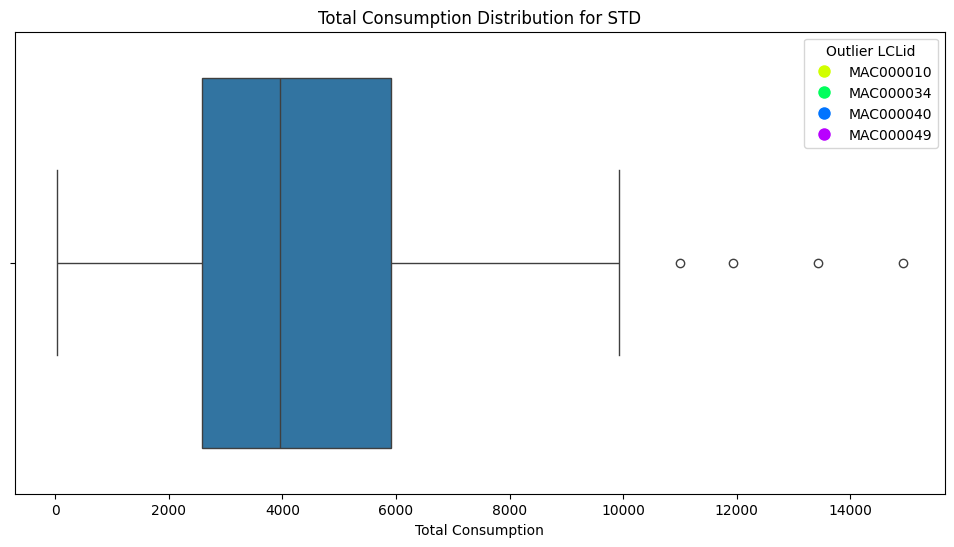

Unique outliers:
        LCLid  TotalConsumption
34  MAC000257      11525.505647


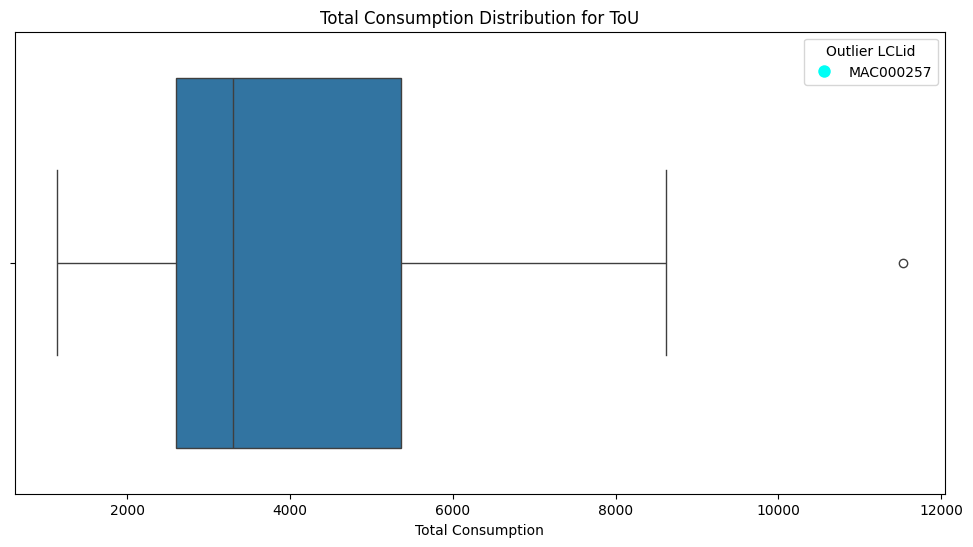

In [ ]:
# Identify outliers for STD using the IQR method
std_outliers = identify_outliers_iqr(std_total)

# Identify outliers for ToU using the IQR method
tou_outliers = identify_outliers_iqr(tou_total)

# Plot the example distribution with a custom title
std_outlier_lclid = plot_total_consumption_distribution(std_total, std_outliers, 'Total Consumption Distribution for STD')

# Plot the example distribution with a custom title
tou_outlier_lclid = plot_total_consumption_distribution(tou_total, tou_outliers, 'Total Consumption Distribution for ToU')


###**Plot the Graphs for Outliers present in STD & ToU**

## **Loading Weather Data**

In [ ]:
weather_data = pd.read_csv('/content/drive/MyDrive/open-meteo-51.49N0.16W23m (1).csv', skiprows=3)

In [ ]:
weather_data.head()

,time,temperature_2m (°C)
0,2010-01-01T00:00,0.4
1,2010-01-01T01:00,0.3
2,2010-01-01T02:00,0.1
3,2010-01-01T03:00,-0.2
4,2010-01-01T04:00,-0.4


In [ ]:
# Convert 'time' column to datetime objects, coerce errors to handle inconsistencies
weather_data['time'] = pd.to_datetime(weather_data['time'], errors='coerce')

# Drop rows with NaT in 'time' column (result of conversion errors)
weather_data = weather_data.dropna(subset=['time'])

# Filter the DataFrame for the specified date range
start_date = "2013-01-01"
end_date = "2014-02-28"
mask = (weather_data['time'] >= start_date) & (weather_data['time'] <= end_date)
filtered_weather_data = weather_data.loc[mask]
filtered_weather_data.reset_index(drop=True, inplace=True)

# Display the filtered DataFrame
# Format the 'time' column to the desired format without the "T"
filtered_weather_data['time'] = filtered_weather_data['time'].dt.strftime("%Y-%m-%d %H:%M")

# Display the filtered and formatted DataFrame
print(filtered_weather_data.head())


               time temperature_2m (°C)
0  2013-01-01 00:00                 8.6
1  2013-01-01 01:00                 8.3
2  2013-01-01 02:00                 7.5
3  2013-01-01 03:00                 6.8
4  2013-01-01 04:00                 5.9


<ipython-input-41-48dcf8a3d51b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_weather_data['time'] = filtered_weather_data['time'].dt.strftime("%Y-%m-%d %H:%M")


In [ ]:
filtered_weather_data.to_csv('filtered_weather_data.csv')

# **EDA**

In [ ]:
std_data_clean = std_data_imputed.copy()

In [ ]:
std_data_clean.columns

Index(['LCLid', 'DateTime', 'Consumption', 'Hour', 'Month'], dtype='object')

In [ ]:
tou_data_clean = tou_data_imputed.copy()

In [ ]:
# Drop columns 'Hour' and 'Month'
std_data_clean = std_data_clean.drop(columns=['Hour', 'Month'])
tou_data_clean = tou_data_clean.drop(columns=['Hour', 'Month'])

In [ ]:
std_data_clean.columns

Index(['LCLid', 'DateTime', 'Consumption'], dtype='object')

In [ ]:
std_data_clean.columns

Index(['LCLid', 'DateTime', 'Consumption'], dtype='object')

In [ ]:
std_data_clean

,LCLid,DateTime,Consumption
0,MAC000002,2013-01-01 00:00:00,0.219
1,MAC000002,2013-01-01 00:30:00,0.241
2,MAC000002,2013-01-01 01:00:00,0.191
3,MAC000002,2013-01-01 01:30:00,0.235
4,MAC000002,2013-01-01 02:00:00,0.182
...,...,...,...
1015943,MAC000068,2014-02-27 21:30:00,0.458
1015944,MAC000068,2014-02-27 22:00:00,0.538
1015945,MAC000068,2014-02-27 22:30:00,0.924
1015946,MAC000068,2014-02-27 23:00:00,0.876


In [ ]:
# Set 'DateTime' as the index
std_data_clean.set_index('DateTime', inplace=True)
tou_data_clean.set_index('DateTime', inplace=True)

#print("Index set successfully")

# Group by 'LCLid' and resample by hour, then aggregate the data
std_hourly_df = std_data_clean.groupby('LCLid').resample('H').agg({'Consumption': 'sum'}).reset_index()
tou_hourly_df = tou_data_clean.groupby('LCLid').resample('H').agg({'Consumption': 'sum'}).reset_index()

print(std_hourly_df)
print(tou_hourly_df)

            LCLid            DateTime  Consumption
0       MAC000002 2013-01-01 00:00:00        0.460
1       MAC000002 2013-01-01 01:00:00        0.426
2       MAC000002 2013-01-01 02:00:00        0.411
3       MAC000002 2013-01-01 03:00:00        0.395
4       MAC000002 2013-01-01 04:00:00        0.221
...           ...                 ...          ...
507595  MAC000068 2014-02-27 19:00:00        1.271
507596  MAC000068 2014-02-27 20:00:00        1.953
507597  MAC000068 2014-02-27 21:00:00        0.962
507598  MAC000068 2014-02-27 22:00:00        1.462
507599  MAC000068 2014-02-27 23:00:00        1.182

[507600 rows x 3 columns]
            LCLid            DateTime  Consumption
0       MAC000005 2013-01-01 00:00:00        0.207
1       MAC000005 2013-01-01 01:00:00        0.106
2       MAC000005 2013-01-01 02:00:00        0.069
3       MAC000005 2013-01-01 03:00:00        0.065
4       MAC000005 2013-01-01 04:00:00        0.058
...           ...                 ...          ...
5075

In [ ]:
std_hourly_df.to_csv('std_hourly_df.csv')
tou_hourly_df.to_csv('tou_hourly_df.csv')

In [ ]:
# Pivoting STD Hourly dataframe
std_pivoted_df = std_hourly_df.pivot(index='LCLid', columns='DateTime', values='Consumption')
std_pivoted_df.columns.name = None
std_pivoted_df.reset_index(inplace=True)

In [ ]:
std_pivoted_df

,LCLid,2013-01-01 00:00:00,2013-01-01 01:00:00,2013-01-01 02:00:00,2013-01-01 03:00:00,2013-01-01 04:00:00,2013-01-01 05:00:00,2013-01-01 06:00:00,2013-01-01 07:00:00,2013-01-01 08:00:00,...,2014-02-27 14:00:00,2014-02-27 15:00:00,2014-02-27 16:00:00,2014-02-27 17:00:00,2014-02-27 18:00:00,2014-02-27 19:00:00,2014-02-27 20:00:00,2014-02-27 21:00:00,2014-02-27 22:00:00,2014-02-27 23:00:00
0,MAC000002,0.460,0.426,0.411,0.395,0.221,0.206,0.206,0.217,0.216,...,0.213,0.212,0.212,0.228,0.667,1.700,2.259,1.000,1.766,2.465
1,MAC000003,3.888,2.603,2.159,2.040,1.495,1.044,0.807,0.227,0.150,...,0.142,0.095,0.149,0.202,0.292,0.933,0.616,0.170,0.159,0.111
2,MAC000004,0.000,0.158,0.000,0.170,0.000,0.000,0.176,0.000,0.176,...,0.223,0.000,0.000,0.164,0.000,0.112,0.039,0.000,0.167,0.000
3,MAC000006,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.068,0.090,...,0.066,0.068,0.043,0.051,0.317,0.296,0.228,0.265,0.114,0.053
4,MAC000007,0.451,0.375,0.312,0.199,0.096,0.167,0.150,0.164,0.135,...,0.267,0.135,0.135,0.171,0.910,1.801,0.381,0.440,0.628,0.277
5,MAC000009,0.287,0.240,0.233,0.181,0.161,0.171,0.138,0.182,0.157,...,0.210,0.350,0.367,0.507,0.446,0.440,0.472,0.421,0.531,0.337
6,MAC000010,0.962,1.121,0.373,0.421,0.303,0.450,0.389,0.452,0.703,...,0.515,0.701,0.621,1.768,2.507,2.298,2.036,1.065,1.012,0.918
7,MAC000011,0.579,1.340,1.431,0.413,0.230,0.294,0.301,0.278,0.460,...,0.338,0.448,1.417,1.850,0.960,0.671,0.592,0.504,0.316,0.215
8,MAC000012,0.016,0.107,0.024,0.010,0.107,0.022,0.009,0.106,0.009,...,0.000,0.082,0.084,0.000,0.050,0.102,0.011,0.019,0.104,0.024
9,MAC000013,0.660,0.420,0.242,0.149,0.280,0.207,0.139,0.230,0.258,...,0.147,0.198,0.151,0.292,0.223,0.318,0.251,0.346,0.258,0.234


In [ ]:
# Pivoting ToU Hourly dataframe
tou_pivoted_df = tou_hourly_df.pivot(index='LCLid', columns='DateTime', values='Consumption')
tou_pivoted_df.columns.name = None
tou_pivoted_df.reset_index(inplace=True)

In [ ]:
tou_pivoted_df

,LCLid,2013-01-01 00:00:00,2013-01-01 01:00:00,2013-01-01 02:00:00,2013-01-01 03:00:00,2013-01-01 04:00:00,2013-01-01 05:00:00,2013-01-01 06:00:00,2013-01-01 07:00:00,2013-01-01 08:00:00,...,2014-02-27 14:00:00,2014-02-27 15:00:00,2014-02-27 16:00:00,2014-02-27 17:00:00,2014-02-27 18:00:00,2014-02-27 19:00:00,2014-02-27 20:00:00,2014-02-27 21:00:00,2014-02-27 22:00:00,2014-02-27 23:00:00
0,MAC000005,0.207,0.106,0.069,0.065,0.058,0.068,0.069,0.086,0.447,...,0.096,0.174,0.111,0.060,1.095,0.464,0.330,0.169,0.361,0.220
1,MAC000014,0.053,0.049,0.060,0.050,0.046,0.045,0.062,0.085,0.117,...,0.250,0.281,0.343,0.403,0.288,0.350,0.274,0.378,0.261,0.070
2,MAC000015,0.293,0.252,0.254,0.252,0.205,0.220,0.281,0.198,0.215,...,0.635,0.433,0.339,0.489,0.367,0.309,0.348,0.778,0.714,0.333
3,MAC000017,0.137,0.112,0.106,0.097,0.110,0.092,0.085,0.168,0.205,...,0.164,0.144,0.287,0.319,0.448,0.630,0.462,0.541,0.649,0.791
4,MAC000031,0.451,0.467,0.490,0.580,0.579,0.509,0.594,0.616,0.525,...,0.401,0.335,1.501,1.844,2.804,3.331,2.121,0.940,0.887,0.662
5,MAC000044,0.473,0.329,0.116,0.131,0.224,0.222,0.220,0.218,0.175,...,0.515,0.792,1.052,1.047,0.431,0.695,0.739,0.469,0.445,0.405
6,MAC000046,0.459,0.406,0.402,0.222,0.101,0.098,0.090,0.262,0.411,...,0.553,1.201,1.333,1.385,1.259,0.715,0.447,0.509,0.549,0.537
7,MAC000048,0.105,0.106,0.107,0.108,0.128,0.158,0.106,0.105,0.105,...,0.397,0.385,0.441,0.359,1.500,0.683,0.439,0.404,0.754,0.273
8,MAC000051,0.565,0.590,0.616,1.239,1.123,0.263,0.185,0.335,0.266,...,0.206,0.495,1.568,0.705,0.466,0.502,0.660,0.656,0.752,0.656
9,MAC000052,0.191,0.165,0.129,0.118,0.080,0.084,0.081,0.060,0.096,...,0.215,0.821,0.944,0.784,0.967,0.055,0.061,0.075,0.104,0.082


## **Normalization**

In [ ]:
normalized_std_df = normalize_time_series_data(std_pivoted_df)
normalized_tou_df = normalize_time_series_data(tou_pivoted_df)

## **Performing Kmeans Cluster with DTW**

In [ ]:
# Perform clustering with 3 clusters for std_pivoted_df
clustered_std_df, kmeans_std = perform_dtw_clustering(normalized_std_df, n_clusters=3)
plot_clusters(clustered_std_df, kmeans_std)

In [ ]:
# Perform clustering with 3 clusters for tou_pivoted_df
clustered_tou_df, kmeans_tou = perform_dtw_clustering(normalized_tou_df, n_clusters=3)
plot_clusters(clustered_tou_df, kmeans_tou)